In [6]:
import time
import copy

import torch
import torch.nn
import torch.optim

import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from IPython.display import set_matplotlib_formats, display
set_matplotlib_formats('pdf', "svg")
import matplotlib.pyplot as plt

import ThinLens.Beam
import ThinLens.Models
import ThinLens.Elements

create model

Text(0, 0.5, 'beta / m')

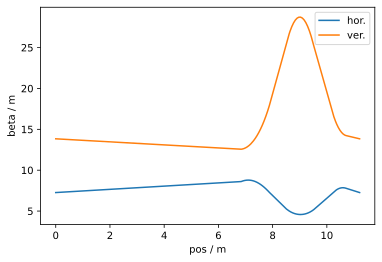

In [7]:
Lattice = ThinLens.Models.SIS18_Cell_minimal_noDipoles
model = Lattice(slices=4)  # 0-F-0-D-0-F-0

# visualize beta-function
twiss = model.getTwiss()

plt.plot(twiss["s"], twiss["betx"], label="hor.")
plt.plot(twiss["s"], twiss["bety"], label="ver.")
plt.legend()
plt.xlabel("pos / m")
plt.ylabel("beta / m")

track some particles

Text(0, 0.5, 'x / m')

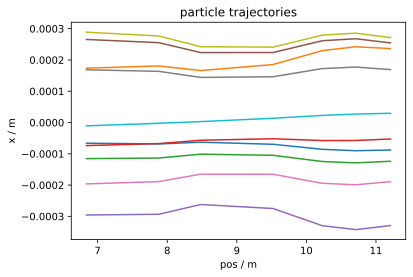

In [8]:
beam = ThinLens.Beam.Beam(mass=18.798, energy=19.0, exn=1.258e-5, eyn=2.005e-5, sigt=0.01, sige=0.005, particles=int(1e3))

trackedBunch = model(beam.bunch, outputPerElement=True)  # indices: particle, dim, element

# visualize
fig, ax = plt.subplots()
for particle in trackedBunch[:10].detach():
    ax.plot(model.endPositions, particle[0])

ax.set_title("particle trajectories")
ax.set_xlabel("pos / m")
ax.set_ylabel("x / m")

create a perturbed model and train it

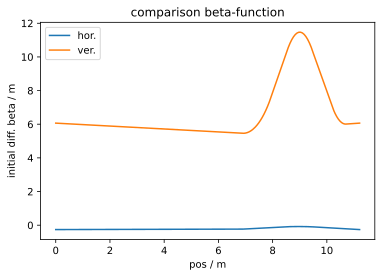

In [9]:
perturbedModel = Lattice(k1f:=3.19391e-01, k1d=-4.7047e-01, slices=4)
perturbedModelNoTraining = copy.deepcopy(model)  # preserve initial state for comparison

# compare beta-function
perturbedTwiss = perturbedModel.getTwiss()
plt.plot(perturbedTwiss["s"], perturbedTwiss["betx"] - twiss["betx"], label="hor.")
plt.plot(perturbedTwiss["s"], perturbedTwiss["bety"] - twiss["bety"], label="ver.")

plt.legend()
plt.title("comparison beta-function")
plt.xlabel("pos / m")
plt.ylabel("initial diff. beta / m")

betaYLimBeforeTraining = plt.ylim()

In [10]:
# deactivate gradient computation for all weights
model.requires_grad_(False)
perturbedModel.requires_grad_(False)

# choose which parameters shall be trained
trainableParameters, trainableParametersTarget = list(), list()
for i, element in enumerate(perturbedModel.elements):
    if type(element) is ThinLens.Elements.Quadrupole:
        element.k1n.requires_grad_(True)  # quadrupole kick strength
        element.k2n.requires_grad_(False)  # sextupole kick strength
        
        trainableParameters.append(element.k1n)
        trainableParametersTarget.append(model.elements[i])

# prepare dataset for trainig
bunch = beam.bunch.detach().clone()
label = model(beam.bunch, outputPerElement=True)

trainSet = torch.utils.data.TensorDataset(bunch, label)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=25,
                                          shuffle=True, num_workers=2)

# set up optimizer
optimizer = torch.optim.Adam(perturbedModel.parameters(), lr=5e-2)
criterion = torch.nn.MSELoss()

In [11]:
epochs = 10

# train loop
t0 = time.time()

# log initial parameters
parameterLog = dict()
for param in trainableParameters:
    parameterLog[param] = [param.item(),]

for epoch in range(epochs):
    for i, data in enumerate(trainLoader, 0):
        bunch, label = data[0], data[1]

        optimizer.zero_grad()

        out = perturbedModel(bunch, outputPerElement=True,)

#         loss = criterion(out, label)  # full phase-space
        loss = criterion(out[:, [0, 2], :], label[:, [0, 2], :])  # transversal coordinates only

        loss.backward()
        optimizer.step()
        
        # log parameters
        for param in trainableParameters:
            parameterLog[param].append(param.item())

    print(loss.item())

print("training completed within {:.2f}s".format(time.time() - t0))

2.6144072620819135e-13
1.1052078873184212e-13
2.6856262320732476e-14
1.4631288395754642e-14
1.3627671030259886e-14
8.149402671725547e-15
5.223655612404961e-15
2.126074605264184e-15
8.365177350895194e-16
8.429096171250744e-16
training completed within 14.58s


check model performance after training

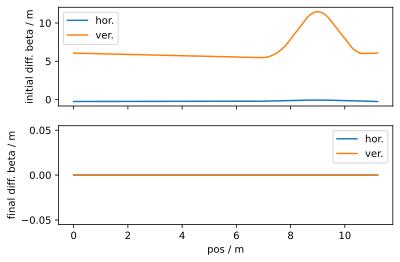

In [13]:
trainedTwiss = model.getTwiss()

# compare beta-function
figBeta, axBeta = plt.subplots(2, 1, sharex=True)

axBeta[0].plot(perturbedTwiss["s"], perturbedTwiss["betx"] - twiss["betx"], label="hor.")
axBeta[0].plot(perturbedTwiss["s"], perturbedTwiss["bety"] - twiss["bety"], label="ver.")

axBeta[1].plot(trainedTwiss["s"], trainedTwiss["betx"] - twiss["betx"], label="hor.")
axBeta[1].plot(trainedTwiss["s"], trainedTwiss["bety"] - twiss["bety"], label="ver.")

axBeta[0].legend()
axBeta[0].set_ylabel("initial diff. beta / m")

# axBeta[1].set_ylim(axBeta[0].get_ylim())
axBeta[1].legend()
axBeta[1].set_ylabel("final diff. beta / m")
axBeta[1].set_xlabel("pos / m")

fig.tight_layout()
fig.savefig("/dev/shm/SIS18_xMagnitudeBPM.pdf", bbox_inches="tight", pad_inches=0)


display evolution of parameters

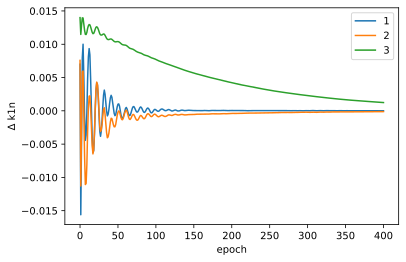

In [14]:
figPara, axPara = plt.subplots()

for i, param in enumerate(trainableParameters):
    # target value
    element = trainableParametersTarget[i]
   
    targetValue = element.k1n.item()
    
    evolution = np.array(parameterLog[param]) - targetValue
    
    axPara.plot(evolution, label=str(i + 1))

axPara.legend()
axPara.set_xlabel("epoch")
axPara.set_ylabel(r"$\Delta$ k1n")

fig.tight_layout()
fig.savefig("/dev/shm/FODO_parameterEvolution.pdf", bbox_inches="tight", pad_inches=0)
    